In [1]:
!pip install scikit-learn==1.1.3

In [2]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
import warnings

# Телеком

Задача -  На основании признаков, предоставленной телеком  компанией построить модель классификации, предсказывающую  отток клиентов.
Модель машинного обучения должна обладать метрикой ROC-AUC не ниже 0.85


# Обзор данных

**Информация о личных данных клиента**

In [3]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

Описание признаков в датасете: 
* customerID - идентификационный номер клиентов
* gender -  пол
* SeniorCitizen - является ли клиент городским жителем
* Partner -  наличие супруга
* Dependents - наличие иждивенцев

In [4]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [5]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


* неодинаковый стиль обозначения признаков
* отсутствие пропусков

Просмотр уникальных значений признаков

In [6]:
columns = df_personal.drop('customerID',axis=1).columns
for column in columns:
    print( column, '-', df_personal[column].unique())

gender - ['Female' 'Male']
SeniorCitizen - [0 1]
Partner - ['Yes' 'No']
Dependents - ['No' 'Yes']


Признаки имеют ожидаемое значение

**Информация о договоре**

In [7]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

Описание признаков 
* customerID - идентификационный номер клиентов
* BeginDate - дата начала пользования услугами
* EndDate - дата окончания пользования услугами
* Type - тип договора: ежемесячный, годовой и т.д.
* PaperlessBilling - факт выставления счета на электронную почту
* PaymentMethod - способ оплаты
* MonthlyCharges - всего потрачено на услуги в месяц
* TotalCharges - всего потрачено денег на услуги
* Dependents - наличие иждивенцев


In [8]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


* неодинаковый стиль описания признаков
* отсутствуют пропуски
* обектный тип во временых признаках
* обектный тип в итоговых расходах

Анализ расходов клиентов на связь

In [10]:
#  изменение расходов на вещественный тип
df_contract['TotalCharges'] =  pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

Статистики по расходам всех клиентов

In [11]:
df_contract[['MonthlyCharges','TotalCharges']].describe()

MonthlyCharges  TotalCharges
count     7043.000000   7032.000000
mean        64.761692   2283.300441
std         30.090047   2266.771362
min         18.250000     18.800000
25%         35.500000    401.450000
50%         70.350000   1397.475000
75%         89.850000   3794.737500
max        118.750000   8684.800000

Расходы ушедших и оставшихся клиентов

In [12]:
df_charges_departed = df_contract.query('EndDate != "No"')[['MonthlyCharges','TotalCharges']].describe()
df_charges_stay = df_contract.query('EndDate == "No"')[['MonthlyCharges','TotalCharges']].describe()

Статистики по расходам для отдельных групп клиентов

In [13]:
pd.concat([df_charges_stay,df_charges_departed],axis = 1,keys = ['stay','departed'])

stay                    departed             
      MonthlyCharges TotalCharges MonthlyCharges TotalCharges
count    5174.000000  5163.000000    1869.000000  1869.000000
mean       61.265124  2555.344141      74.441332  1531.796094
std        31.092648  2329.456984      24.666053  1890.822994
min        18.250000    18.800000      18.850000    18.850000
25%        25.100000   577.825000      56.150000   134.500000
50%        64.425000  1683.600000      79.650000   703.550000
75%        88.400000  4264.125000      94.200000  2331.300000
max       118.750000  8672.450000     118.350000  8684.800000

* Общие расходы выше у оставшихся клиентов, вероятно по причине более длительного пользования услугами компании
* Ежемесячные средние и медианные  расходы у ушедших клиентов выше, возможно они более склонны к перерасходу фиксированного тарифа или не оптимально подобранный  тариф
* СКО расходов у ушедших клиентов ниже, это показывает что цена является важнейшим фактором ухода  

Гистограммы месячных расходов

Text(0, 0.5, 'Количество клиентов ')

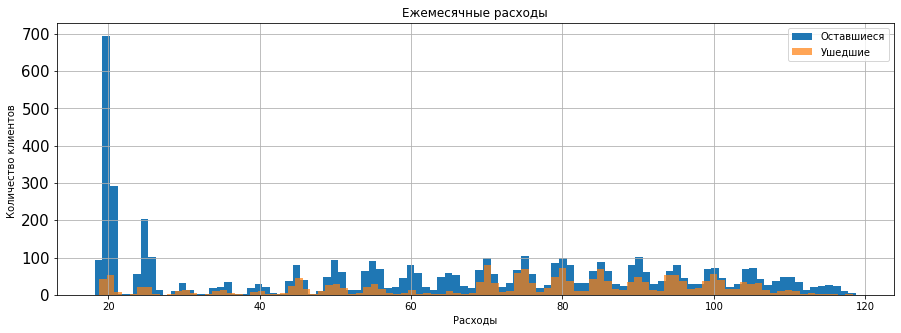

In [14]:
plt.figure(figsize=(15, 5))
plt.title('Ежемесячные расходы')
df_contract.query('EndDate == "No"')['MonthlyCharges'].hist(bins=100,ylabelsize = 15,legend = True)  
df_contract.query('EndDate != "No"')['MonthlyCharges'].hist(bins=100,ylabelsize = 15,alpha =0.7,legend = True)
plt.legend(['Оставшиеся','Ушедшие'])
plt.xlabel('Расходы')
plt.ylabel('Количество клиентов ')

* Ежемесячные расходы сконцентрированы вокруг значений кратных 5, что логично, так как ценна тарифа должна иметь красивое число

**Информация об услугах телефонии**                        

In [15]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [16]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [17]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


* неодинаковый стиль описания признаков
* отсутствуют пропуски

Уникальные значения признака

In [18]:
df_phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Признак имеет ожидаемое значение

**Информация об интернет услугах** 

In [19]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

Описание признаков 
* customerID - идентификационный номер клиента
* InternetService - тип подключения к интернету
* OnlineSecurity - блокировка небезопасных сайтов
* OnlineBackup - облачное хранилище файлов для резервного копирования данных
* DeviceProtection - антивирус
* TechSupport - выделенная линия технической поддержки
* StreamingTV - стриминговое телевидение
* StreamingMovies - каталог фильмов

In [20]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [21]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Уникальные значения признаков

In [22]:
columns = df_internet.drop('customerID',axis=1).columns
for column in columns:
    print( column, '-', df_internet[column].unique())

InternetService - ['DSL' 'Fiber optic']
OnlineSecurity - ['No' 'Yes']
OnlineBackup - ['Yes' 'No']
DeviceProtection - ['No' 'Yes']
TechSupport - ['No' 'Yes']
StreamingTV - ['No' 'Yes']
StreamingMovies - ['No' 'Yes']


Признаки имеют ожидаемое значение

**Доли оставшихся и ушедших клиентов**

(-1.25, 1.25, -1.25, 1.25)

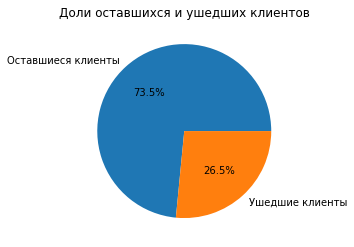

In [23]:
pd.Series([df_contract.query('EndDate == "No"')['customerID' ].count(),
           df_contract.query('EndDate != "No"')['customerID' ].count()])\
.plot(kind='pie',autopct='%1.1f%%',labels=['Оставшиеся клиенты','Ушедшие клиенты'])
plt.title('Доли оставшихся и ушедших клиентов')
plt.axis('off')


* Компания потяряла четверть клиентов
* Присутствует небольшой дисбаланс классов

Вывод по разделу:
* неодинаковый стиль названия признаков
* отсутствуют пропуски
* не везде данные приведены к нужному типу
* неодинаковое количество клиентов в датасетах

# Интерпретация данных и предобработка

In [24]:
# убрать экспонентациальные формы при выводе данных
pd.set_option('display.float_format', '{:,.2f}'.format)

# отключение предупреждения в коде
warnings.filterwarnings("ignore")

In [25]:
RANDOM_STATE = 130323

Приведение названий признаков к единому стилю

In [26]:
for df in [df_contract,df_personal,df_internet,df_phone]:
    camel_case_list = df.columns

    snake_case_list = []
    for var in camel_case_list:
        snake_case = re.sub('([a-z0-9])([A-Z])', r'\1_\2', var).lower()
        snake_case_list.append(snake_case)
    df.columns = snake_case_list

Изменение типа

In [27]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

Создание новых признаков 

In [28]:
begin_departed = df_contract.query('end_date != "No"')['begin_date']
end_departed = pd.to_datetime(df_contract.query('end_date != "No"')['end_date'], format='%Y-%m-%d')

df_contract['duration']=(end_departed-begin_departed).dt.days

begin_stay = pd.to_datetime(df_contract.query('end_date == "No"')['begin_date'], format='%Y-%m-%d')

df_contract['duration'][df_contract['duration'].isna()] = (pd.to_datetime('2020-02-01', format='%Y-%m-%d')-begin_stay).dt.days

Text(0, 0.5, 'Количество клиентов ')

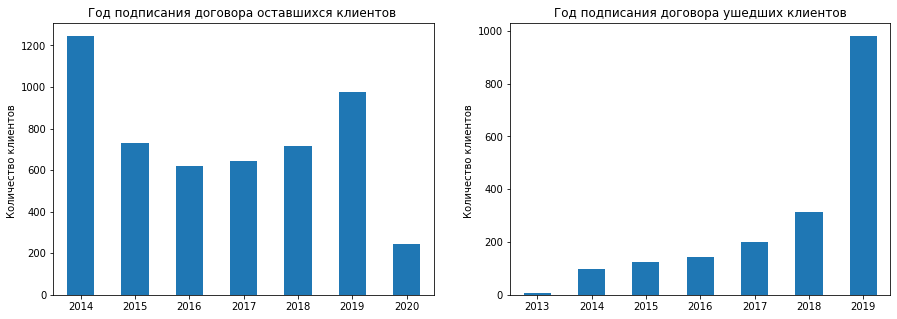

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

df_contract.query('end_date == "No"')['begin_date'].dt.year.value_counts().sort_index().plot(kind='bar',rot = 0)
plt.title('Год подписания договора оставшихся клиентов ')
plt.ylabel('Количество клиентов ')


plt.subplot(1, 2, 2)
df_contract.query('end_date != "No"')['begin_date'].dt.year.value_counts().sort_index().plot(kind='bar',rot = 0)
plt.title('Год подписания договора ушедших клиентов')
plt.ylabel('Количество клиентов ')


* Обращает внимание тенденция ухода именно новых клиентов

Text(0, 0.5, 'Количество клиентов ')

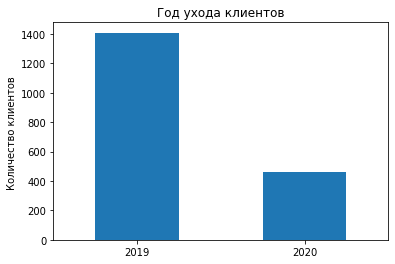

In [30]:
pd.to_datetime(df_contract.query('end_date != "No"')['end_date'], format='%Y-%m-%d')\
    .dt.year.value_counts().sort_index().plot(kind='bar',rot = 0)
plt.title('Год ухода клиентов')
plt.ylabel('Количество клиентов ')

* С учетом того что данные за 2020 лишь за один месяц, наблюдается не очень хорошая ускоряющаяся тенденция, даже при условии роста подписанных клиентов в 2019 году

Длительность времени действия договора

Text(0.5, 1.0, 'Гистограмма частоты времени действия договора клиента')

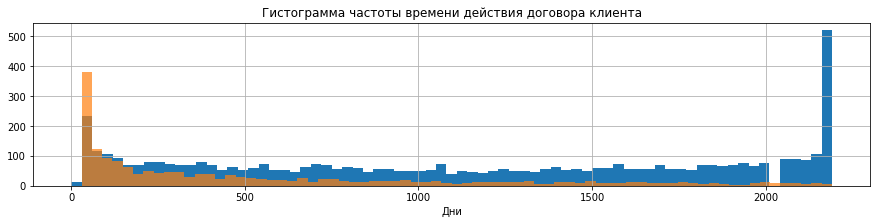

In [31]:
plt.figure(figsize=(15, 3))
months = int(df_contract['duration'].max()/30)
df_contract.query('end_date == "No"')['duration'].hist(bins= months)


# months = int(df_contract['duration'].max()/30)
df_contract.query('end_date != "No"')['duration'].hist(bins= months,alpha = .7)
plt.xlabel('Дни')
plt.title('Гистограмма частоты времени действия договора клиента')

* Решение уйти клиент принимает в течении нескольких месяцев

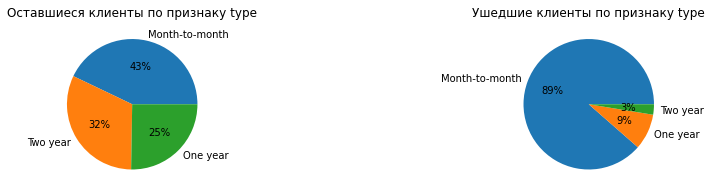

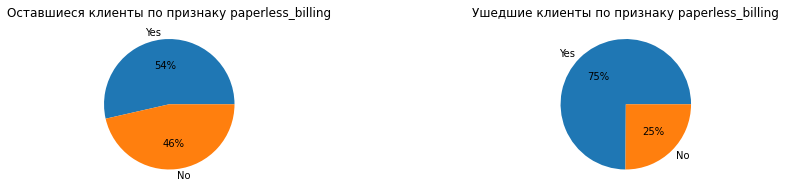

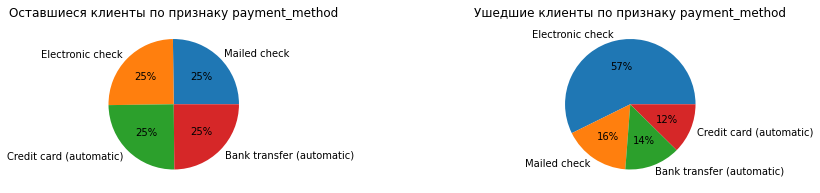

In [32]:
for column in ['type','paperless_billing','payment_method']:    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    df_contract.query('end_date=="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.0f%%')
    plt.title('Оставшиеся клиенты по признаку '+ column)
    plt.axis('off')
   
    plt.subplot(1, 2, 2)
    df_contract.query('end_date!="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.f%%')
    plt.title('Ушедшие клиенты по признаку ' + column)
    plt.axis('off')
    plt.show()
    print()

* Обращает внимание разная структура ушедших и оставшихся клиентов по методу платежа и типу контракта

# Объединение датасета по ключу идентификационного номера клиента

Анализ влияния признаков личных данных на решение уйти или остаться

In [33]:
df_merged = pd.merge(df_personal,df_contract, how = 'left',on = 'customer_id')

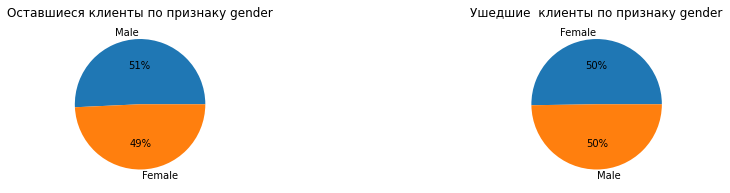

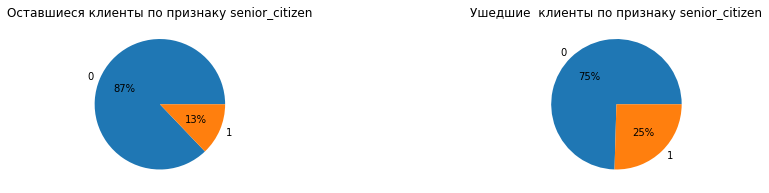

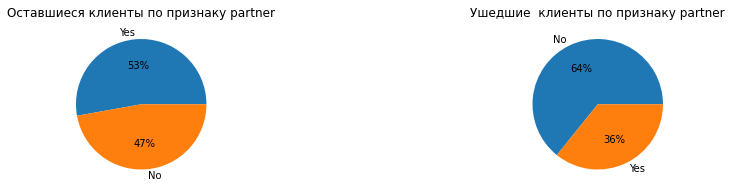

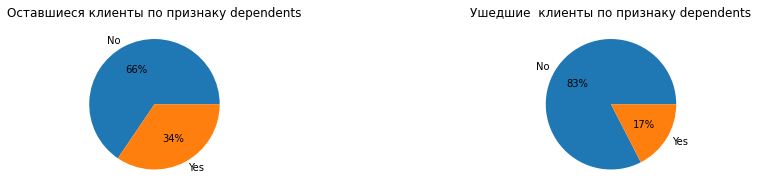

In [34]:
for column in ['gender','senior_citizen','partner','dependents']:    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    df_merged.query('end_date=="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.0f%%')
    plt.title('Оставшиеся клиенты по признаку '+ column)
    plt.axis('off')
   
    plt.subplot(1, 2, 2)
    df_merged.query('end_date!="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.f%%')
    plt.title('Ушедшие  клиенты по признаку ' + column)
    plt.axis('off')
    plt.show()
    print()

* пол не влияния на принятие решение перестать пользоваться услугами компании 

**Добавление информации о интернете и услугах телефонии**

In [35]:
df_merged = pd.merge(df_merged,df_internet, how = 'left',on = 'customer_id')

In [36]:
df_merged = pd.merge(df_merged,df_phone, how = 'left',on = 'customer_id')

Просмотр объединенного датасета

In [37]:
df_merged.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
duration                0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

**Обработка пропусков**

Общие траты

In [38]:
df_merged.query('total_charges.isna()')['begin_date']

488    2020-02-01
753    2020-02-01
936    2020-02-01
1082   2020-02-01
1340   2020-02-01
3331   2020-02-01
3826   2020-02-01
4380   2020-02-01
5218   2020-02-01
6670   2020-02-01
6754   2020-02-01
Name: begin_date, dtype: datetime64[ns]

* Совсем новички, в датасете еще не успели появиться общие расходы

Заполнение общих расходов ежемесячными

In [39]:
df_merged['total_charges'] = df_merged['total_charges'].fillna(df_merged['monthly_charges'])

Так как компания предостовляет стационарную телефонную связь и интернет через DSL или Fiber optic.А клиент пользуется услугами компании значит должен быть хотя бы DSL

In [40]:
df_merged['internet_service'] = df_merged['internet_service'].fillna('DSL')

Так как признаки бинарны и указывают на наличие или отсутствие услуги, то пропуски означают неподключенную услугу.
Значит заполним соответствующим значением

In [41]:
df_merged = df_merged.fillna('No')

Проверка

In [42]:
df_merged.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
duration             0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

**Анализ влияние  интернет услуг на целевой признак** 

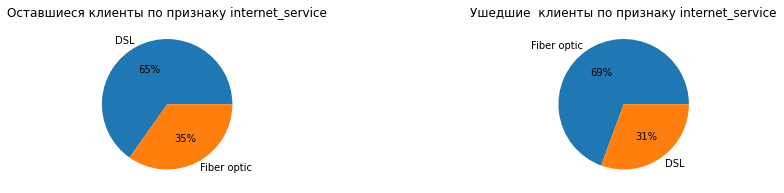

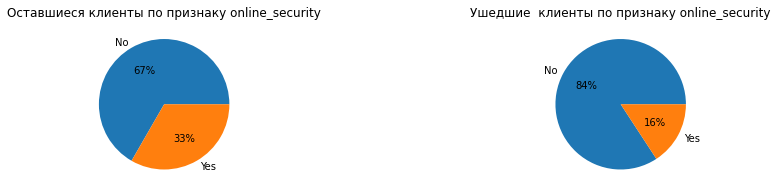

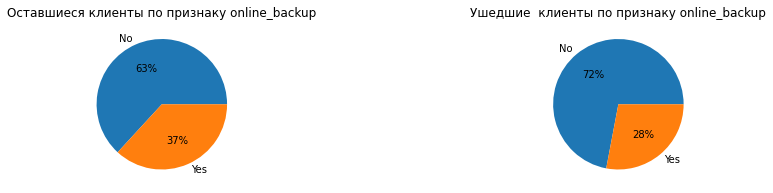

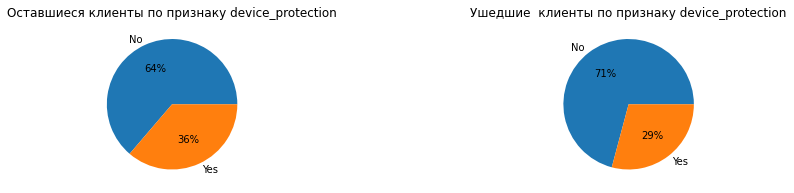

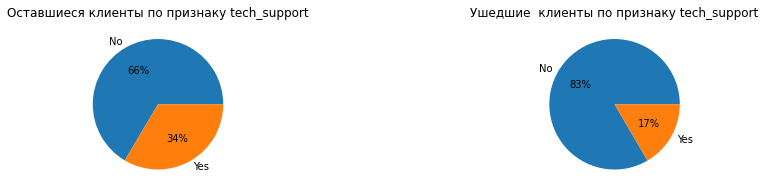

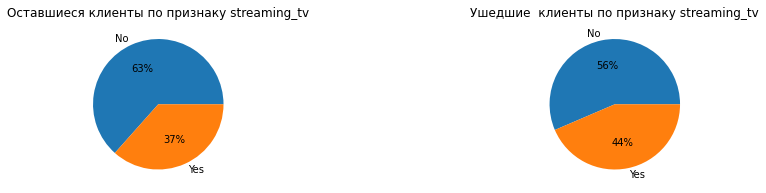

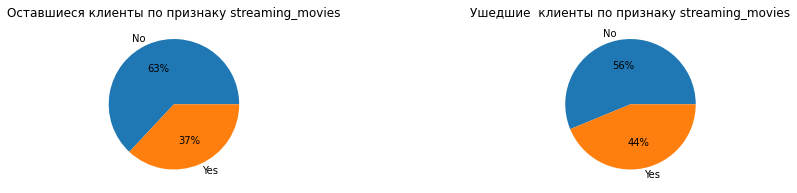

In [43]:
for column in df_internet.drop('customer_id',axis =1).columns:    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    df_merged.query('end_date=="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.0f%%')
    plt.title('Оставшиеся клиенты по признаку '+ column)
    plt.axis('off')
   
    plt.subplot(1, 2, 2)
    df_merged.query('end_date!="No"')[column].value_counts().plot(kind = 'pie',autopct='%1.f%%')
    plt.title('Ушедшие  клиенты по признаку ' + column)
    plt.axis('off')
    plt.show()
    print()

* тип подключения не влияет на решение отказаться от услуг
* стриминговое кино и телевидение одинаковые доли, так имеют сильную связь

In [44]:
df_merged[['monthly_charges','total_charges','duration']].corr()

monthly_charges  total_charges  duration
monthly_charges             1.00           0.65      0.25
total_charges               0.65           1.00      0.83
duration                    0.25           0.83      1.00

* ожидаемая высокая корреляция между месячными и общими расходами

# Предобработка/подготовка датасета для поиска модели машинного обучения

Выделение целевой переменной

In [45]:
df_merged['target'] = 0
df_merged.loc[df_merged['end_date'] !="No", 'target'] = 1


Отбор признаков (без пола и даты)   

In [46]:
features_columns = ['senior_citizen',
                    'partner',
                    'dependents',
                    'type',
                    'paperless_billing',
                    'payment_method',
                    'monthly_charges',
                    'total_charges',
                    'duration',
                    'internet_service',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'multiple_lines']
features = df_merged[features_columns]

target = df_merged['target']



Получение тестовой и тренировочной выборки

In [47]:
train_features,test_features,train_target ,test_target = train_test_split(
                                features, target, test_size = 0.25, random_state = RANDOM_STATE)
# сброс индексов
for df in [train_features,train_target, test_features,test_target]:
     df.reset_index(drop=True, inplace=True)

In [48]:
dimensions = list(map(str,[train_features.shape,test_features.shape,train_target.shape,test_target.shape]))
pd.DataFrame( dimensions, columns = ['dimensions'],
             index =['train_features','test_features','train_target' ,'test_target'] )
    

dimensions
train_features  (5282, 16)
test_features   (1761, 16)
train_target       (5282,)
test_target        (1761,)

Кодирование

In [49]:
categories = list(train_features.select_dtypes(exclude='float64').columns)
num_cols = list(train_features.select_dtypes(include='float64').columns)

In [50]:
train_features_lin = train_features.copy()
test_features_lin = test_features.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(train_features_lin[categories])

# encoder_ohe.categories_
# добавляем закодированные признаки 
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

train_features_lin[
      encoder_ohe.get_feature_names_out()
 ] = encoder_ohe.transform(train_features_lin[categories])

# удаляем незакодированные категориальные признаки (изначальные колонки)
train_features_lin = train_features_lin.drop(categories, axis=1)

Масштабирование для линейных моделей

In [51]:
st = StandardScaler()
train_features_scaler = pd.DataFrame(st.fit_transform(train_features_lin), 
                                               columns =train_features_lin.columns)



# Поиск модели машинного обучения

**Логистическая регрессия**

In [52]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              }            
grid_log_reg = GridSearchCV(LogisticRegression(random_state = RANDOM_STATE), 
            params, cv=5,scoring='roc_auc')

In [53]:
%%time
grid_log_reg.fit(train_features_scaler,train_target)

CPU times: user 6.43 s, sys: 17 s, total: 23.4 s
Wall time: 23.4 s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=130323),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc')

**Метод опорных векторов**

In [54]:
params = {'C': [0.01, 0.1, 1, 10], 
          'gamma': [0.001, 0.01, 1]}     
grid_svc = GridSearchCV(SVC(random_state = RANDOM_STATE), 
            params, cv=5,scoring='roc_auc')

In [55]:
%%time
grid_svc.fit(train_features_scaler,train_target)

CPU times: user 47.9 s, sys: 1.91 s, total: 49.8 s
Wall time: 49.9 s


GridSearchCV(cv=5, estimator=SVC(random_state=130323),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 1]},
             scoring='roc_auc')

**CatBoots**

In [56]:
params = {
             'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
             'depth':[4,6,8,10]
#              'l2_leaf_reg': [1, 3, 5, 7, 9]   
            }

grid_cat = GridSearchCV(CatBoostClassifier(random_state = RANDOM_STATE,cat_features  = categories), 
            params, cv=3,scoring='roc_auc')


In [57]:
%%time
grid_cat.fit(train_features,train_target)

0:	learn: 0.6759802	total: 51.3ms	remaining: 51.2s
1:	learn: 0.6590196	total: 55.5ms	remaining: 27.7s
2:	learn: 0.6447695	total: 59ms	remaining: 19.6s
3:	learn: 0.6307364	total: 62.6ms	remaining: 15.6s
4:	learn: 0.6151210	total: 66.5ms	remaining: 13.2s
5:	learn: 0.6005350	total: 70ms	remaining: 11.6s
6:	learn: 0.5870683	total: 73.4ms	remaining: 10.4s
7:	learn: 0.5751223	total: 76.7ms	remaining: 9.51s
8:	learn: 0.5647456	total: 80.6ms	remaining: 8.88s
9:	learn: 0.5555205	total: 83.7ms	remaining: 8.29s
10:	learn: 0.5465950	total: 87.1ms	remaining: 7.83s
11:	learn: 0.5381944	total: 90.4ms	remaining: 7.44s
12:	learn: 0.5308657	total: 93.3ms	remaining: 7.08s
13:	learn: 0.5238684	total: 96.3ms	remaining: 6.78s
14:	learn: 0.5162932	total: 99.4ms	remaining: 6.53s
15:	learn: 0.5094050	total: 103ms	remaining: 6.31s
16:	learn: 0.5026930	total: 105ms	remaining: 6.09s
17:	learn: 0.4974199	total: 109ms	remaining: 5.94s
18:	learn: 0.4914763	total: 112ms	remaining: 5.79s
19:	learn: 0.4864282	total: 11

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7effbf9a5670>,
             param_grid={'depth': [4, 6, 8, 10],
                         'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3]},
             scoring='roc_auc')

Сводные значения целевой метрики разных моделей

In [58]:
pd.DataFrame([grid_log_reg.best_score_, grid_svc.best_score_, grid_cat.best_score_],
            index = ['LogisticRegression','SVC','CatBoost'],
            columns=['roc_auc'])

roc_auc
LogisticRegression     0.84
SVC                    0.83
CatBoost               0.90

CatBoost показывает лучшую метрику

# Тестирование лучшей модели

Параметры лучшей модели

In [59]:
grid_cat.best_params_

{'depth': 4, 'learning_rate': 0.2}

Метрики на тесте

In [60]:
pd.DataFrame( data = {'roc_auc': roc_auc_score(test_target,grid_cat.predict_proba(test_features)[:, 1]),
                     'recall': recall_score(test_target,grid_cat.predict(test_features)),
                     'presicion' : [precision_score(test_target,grid_cat.predict(test_features))]},
             index = ['CatBoost_test']
             )

roc_auc  recall  presicion
CatBoost_test     0.93    0.72       0.83

* Достигнута целевая метрика ROC_AUC
* 2/3 из всех действительно ушедших клиентов,модель предсказала верно
* Больше 80 % доля действительно ушедших клиентов из всех клиентов, которым модель предсказывает уход 

**Анализ важности признаков**

Text(0.5, 0, '%')

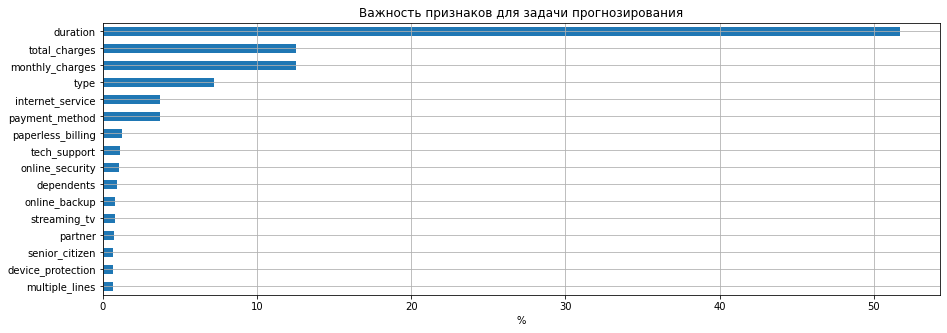

In [61]:
feature_importances = pd.Series(grid_cat.best_estimator_.feature_importances_,index = train_features.columns).sort_values()
plt.figure(figsize = (15,5))
feature_importances.plot(kind = 'barh', grid = True)

plt.title('Важность признаков для задачи прогнозирования' )
plt.xlabel('%')

* Вещественные признаки содержат в себе наиболее значимую информацию о прогнозировании целевой переменой

In [62]:
print('Вклад вещественных признаков - {:,.2f} %'.format(feature_importances[num_cols].sum()))

Вклад вещественных признаков - 76.77 %


На 3 вещественных признака приходиться большая часть вклада в прогноз

**Матрица ошибок**

In [63]:
test_predictions = grid_cat.predict(test_features)
confusion_m = pd.DataFrame(confusion_matrix(test_target, test_predictions,  labels=None, 
                                                 sample_weight=None, normalize=None))
confusion_m.rename(columns={0: 'не покинет',1: 'покинет'},index = {0: 'не покинет',1: 'покинет'},inplace = True)

In [64]:
confusion_m

не покинет  покинет
не покинет        1217       70
покинет            131      343

Text(114.0, 0.5, 'Действительность')

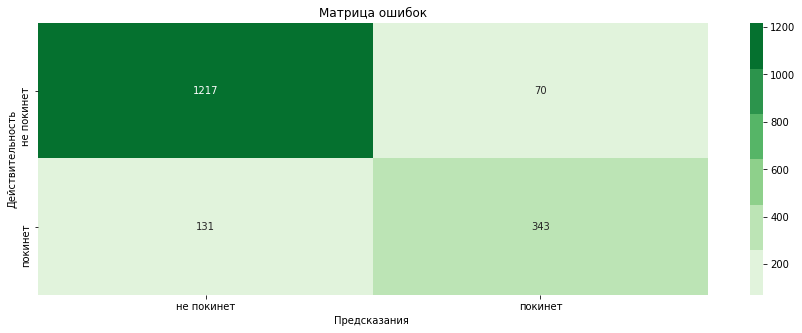

In [65]:
colormap = sns.color_palette("Greens")

plt.figure(figsize=(15,5))
sns.heatmap(confusion_m,annot=True,cmap= colormap,fmt='g' )
plt.title('Матрица ошибок')
plt.xlabel('Предсказания ')
plt.ylabel('Действительность')

* модель допускает в несколько  раз больше ложноотрицательных ошибок чем ложноположительных
* то есть вероятность ошибиться в прогнозе что клиент  не уйдет, при том что он покинет компанию, в несколько раз больше чем уйдет но не покинет компанию

Основные выводы:
* присутствует ускоренная тендеция к потери клиентов, по этой причине для модели самым важным признаком оказался период действия договора
* вещественные признаки имеют доминирующее значение для предсказания
* для модели персональные данные имеют незначительное влияние
* полученная модель демонстрирует метрику в соответствии  с заданием

# Отчет по работе

1. Выполненные этапы согласно плану:
    * Загрузка данных - **выполнено**
    * Знакомство с данными - **выполнено**
    * Интерпретация  данных и предобработка - **выполнено**
    * Объединение датасета по ключу идентификационный номер клиента - **выполнено**
    * Поиск аномалий объединенного датасета - **выполнено**
    * Предобработка/подготовка для поиска модели машинного обучения - **выполнено**
    * Поиск  модели машинного обучения из логистической регрессии, метод опорных векторов, CatBoost - **выполнено**
    * Нахождение и тестирование лучшей модели по метрики ROC-AUC - **выполнено**

2. Основные трудности в решении поставленной  задачи:
    * неполные датасеты (по количеству клиентов)
    * признаки имеют разную значимость  
    * оптимальный подбор параметров модели занимает продолжительное время


3. Ключевые шаги в решении задачи:
    * подготовка данных:
        * выделение нового признака (длительности пользования услугами компании) и его доминирующая важность в решении задачи. Так как этот признак интуитивно не должен быть более значимым чем стоимость оплаты услуг, скорее он является ярким следствием  влияния  других признаков в последнее время


4. Описание итоговой модели

In [66]:
print('Ключевая метрика ROC_AUC для CatBoostClassifier  - {:,.2f} '.format(
    roc_auc_score(test_target,grid_cat.predict_proba(test_features)[:, 1])))

Ключевая метрика ROC_AUC для CatBoostClassifier  - 0.93 


Параметры модели

In [67]:
 grid_cat.best_estimator_.get_params()

{'learning_rate': 0.2,
 'depth': 4,
 'random_state': 130323,
 'cat_features': ['senior_citizen',
  'partner',
  'dependents',
  'type',
  'paperless_billing',
  'payment_method',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'multiple_lines']}

5. Применяемые признаки для обучения модели

In [69]:
pd.DataFrame({'importance' : feature_importances.sort_values(ascending=False)})

importance
duration                51.69
total_charges           12.54
monthly_charges         12.54
type                     7.23
internet_service         3.73
payment_method           3.69
paperless_billing        1.23
tech_support             1.10
online_security          1.03
dependents               0.93
online_backup            0.80
streaming_tv             0.78
partner                  0.75
senior_citizen           0.67
device_protection        0.65
multiple_lines           0.64

Предобработка признаков включала в себя:
   * заполнение пропусков 
   * изменение типа переменных